In [24]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import scipy
import cirq
from qutip import *
from itertools import product
from cvqaoa.circ import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
# Pauli matrices
P = [qeye(2), sigmax(), sigmay(), sigmaz()]

# Create all tensor products
sigma = map(tensor, product(tensP,repeat=2))

In [44]:
def product(*args, repeat=1):
    # product('ABCD', 'xy') --> Ax Ay Bx By Cx Cy Dx Dy
    # product(range(2), repeat=3) --> 000 001 010 011 100 101 110 111
    pools = [tuple(pool) for pool in args] * repeat
    result = [[]]
    for pool in pools:
        result = [x+[y] for x in result for y in pool]
    for prod in result:
        yield list(prod)
        
# Create all tensor products
sigma = map(tensor, product(P,repeat=2))

load kraus operators and create channel

In [9]:
file = '../data/average_gate_fidelity/cv_avg_fid_zz.npz'
data = np.load(file, allow_pickle=True, fix_imports=True)

0.9915549579233776


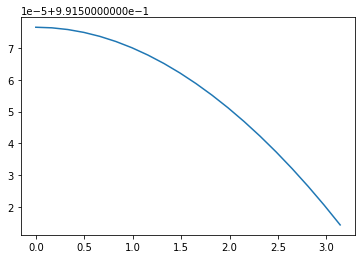

In [21]:
x = data['args']
y = data['avg']
plt.plot(x,y)
print(np.mean(y))

In [8]:
file = '../data/kraus/dv_kraus_rx.npz'
data = np.load(file, allow_pickle=True, fix_imports=True)
kraus_list = data['kraus']

In [77]:
sum(k@np.conj(k.T) for k in kraus_list[2])

array([[ 1.00000000e+00+0.00000000e+00j, -7.76267597e-17-2.59124319e-17j],
       [-7.76267597e-17+2.59124319e-17j,  1.00000000e+00+0.00000000e+00j]])

In [250]:
file = '../data/kraus/cv_kraus_rx.npy'
kraus = np.load(file, allow_pickle=True, fix_imports=True)

given these kraus operators calculate the average gate fidelity

In [6]:
sigma_x = np.array([[0,1],[1,0]], dtype=np.complex64)
sigma_y = np.array([[0,-1j],[1j,0]], dtype=np.complex64)
sigma_z = np.array([[1,0],[0,-1]], dtype=np.complex64)
sigma = [sigma_x, sigma_y, sigma_z]

In [9]:
arg = np.pi / 2
## Ideal gate
U = cirq.unitary(cirq.rx(arg))

## Create quantum circuit
qubits = cirq.LineQubit.range(1)
circuit = cirq.Circuit() # Initialize circuit
circuit.append(cirq.X(qubits[0]) ** (arg/np.pi))
circuit.append(CVRXChannel(arg)(qubits[0]))
sim = cirq.DensityMatrixSimulator(
    split_untangled_states = True,
)
circuit

0: ───X^0.5───DX^1.5707963267948966───

In [13]:
## Average Gate Fidelity
F = 0
for sigma_k in sigma:
    ## Get eigenvalues and eigenvectors
    eVal, eVec = np.linalg.eig(sigma_k)
    
    final_state = 0
    for i in range(2):
        v = np.reshape(eVec[i],(2,1)) # reshape to a column vector
        input_state = v@np.conj(v.T) # input density matrix
        ## Simulate circuit
        result = sim.simulate(
            circuit,
            initial_state=input_state,
            qubit_order=qubits
        )
        final_state += eVal[i]*result.final_density_matrix
    ## Target state
    target_state = U@sigma_k@np.conj(U.T)
    F += np.trace(target_state@final_state).real
avg_fid = (1/2 + 1/12 * F)
print(avg_fid)

0.9861666560173035


The true one is 0.9964767783534642. So I'd say this is close enough!